### Aim

This notebook is a continuation of `pseudobulk-pt2.Rmd`, where DEG analysis is performed between resolving RPRA vs non-resolving RPRA samples from [Bailey et al. bioRxiv 2023](https://www.biorxiv.org/content/10.1101/2023.07.30.551145v1.full#F1).

In this notebook, I will summarize metrics for each cluster. More specifically, I will:
1. Plot DEGs for each cell type as MA plots and heatmaps
1. Plot & return number of DEGs and filtered DEGs for each cluster (Fig. S5A)

Output of this analysis can be found here: 

`../../../data/22deg-analysis/bailey_resolv_vs_nonresolv_v2/pseudobulk/output`

This code also generates Figure S5a.

In [1]:
import collections
import math
import os
import sys

import numpy as np
import pandas as pd
import scanpy as sc
import sc_utils
import pybiomart

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import matplotlib_venn
import adjustText as adjust_text
import seaborn as sns

import goatools.base
import goatools.obo_parser
import goatools.anno.genetogo_reader
import goatools.goea.go_enrichment_ns

/home/kjs6397/.conda/envs/pasc_revisions_venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sys.path.insert(0, "../../../21scArches/lib/")

In [3]:
pd.options.display.max_rows = 1000

In [4]:
DATA_DIR = "/projects/b1038/Pulmonary/ksenkow/Long_COVID_official/data/22deg-analysis/bailey_resolv_vs_nonresolv_v2/pseudobulk/input"

In [5]:
OUT_DIR = "/projects/b1038/Pulmonary/ksenkow/Long_COVID_official/data/22deg-analysis/bailey_resolv_vs_nonresolv_v2/pseudobulk/output"

In [6]:
ds_processed = sc.read_h5ad(f'{DATA_DIR}/bailey_resolv_vs_nonresolv_v2_pseudobulk.h5ad')

In [7]:
ds_processed.raw = ds_processed

### Plot heatmap and MA plot for each cell type
Take gene expression sum instead of mean

Save to output directory

In [8]:
def plot_ma(filtered_degs, title):
    fig, ax = plt.subplots()
    val_counts = filtered_degs.sign.value_counts(dropna=False).sort_index()
    num_top = min(20, val_counts.get("Upregulated", 0))
    num_bot = min(20, val_counts.get("Downregulated", 0))
    genes = filtered_degs.loc[filtered_degs.padj < 0.05, :].index[list(range(num_top)) + list(range(-num_bot, 0))]

    orig_cell_type = None
    for ct in ds_processed.obs.cell_type.unique():
        cand = ct.lower().replace(" ", "_").replace("/", "_")
        if cand == cell_type:
            orig_cell_type = ct
            break
    assert orig_cell_type is not None, f"Could not find original cell type for {cell_type}"
    
    sign_cells = gene_cells.loc[filtered_degs.index[filtered_degs.sign != ""], :].sum(axis=1) # total number of cells expressing this gene if gene is upregulated or downregulated
    min_cells = sign_cells.min()
    max_cells = sign_cells.max()
    colors = {
        "": "gray",
        "Upregulated": lambda x: gene_cells.loc[x.index, :].sum(axis=1),
        "Downregulated": lambda x: gene_cells.loc[x.index, :].sum(axis=1),
    }
    cmap = {
        "": None,
        "Upregulated": mpl.cm.autumn_r,
        "Downregulated": mpl.cm.winter_r,
    }
    alphas = {
        "": 0.2,
        "Upregulated": 1,
        "Downregulated": 1
    }
    labels = {
        "": "",
        "Upregulated": "Up in resolving PASC",
        "Downregulated": "Up in non-resolving PASC"
    }
    processed = []
    for k, v in val_counts.items():
        idx = filtered_degs.sign == k
        kwargs = {}
        label = labels[k]
        if label:
            label = f"{label} ({idx.sum()})"
        kwargs["label"] = label
        c = colors[k]
        if callable(c):
            c = c(filtered_degs[idx])
            kwargs["norm"] = mpl.colors.LogNorm(vmin=min_cells, vmax=max_cells)
        kwargs["c"] = c
        kwargs["alpha"] = alphas[k]
        if cmap.get(k):
            kwargs["cmap"] = cmap[k]
        dots = ax.scatter(
            filtered_degs.baseMean[idx], 
            filtered_degs.log2FoldChange[idx],
            s=4,
            **kwargs
        )
        if kwargs.get("norm"):
            fig.colorbar(dots, label="No of cells with gene")
            processed.append(k)
    texts = []
    for r in filtered_degs.loc[genes, :].itertuples(name=None):
        texts.append(ax.text(r[1], r[2], r[0], size=9))
    ax.set_xscale("log")
    ax.figure.set_size_inches(8, 6)
    ax.set_title(orig_cell_type)
    ax.set_ylabel("$log_2$(fold change)", size=16)
    ax.set_xlabel("Mean expression", size=16)
    l = ax.legend(fontsize=12, markerscale=4)
    for lh in l.legendHandles: 
        lh.set_alpha(1)
    fig.axes[0].set_position((0.1, 0.1, 0.72, 0.85))
    for i, d in enumerate(processed):
        if d == "Downregulated":
            fig.axes[i + 1].set_position((0.84, 0.12, 0.08, 0.375))
        else:
            fig.axes[i + 1].set_position((0.84, 0.52, 0.08, 0.375))
    return fig

In [9]:
def plot_heatmap(filtered_degs, cell_type):
    groupby = "sample"
    val_counts = filtered_degs.sign.value_counts(dropna=False)
    num_top = min(20, val_counts.get("Upregulated", 0))
    num_bot = min(20, val_counts.get("Downregulated", 0))
    # select for DEGs with padj<0.05, subset on genes with highest & lowest logFC
    genes = filtered_degs.loc[filtered_degs.padj < 0.05, :].index[list(range(num_top)) + list(range(-num_bot, 0))]
    
    if num_top + num_bot == 0:
        return None

    orig_cell_type = None
    for ct in ds_processed.obs.cell_type.unique():
        cand = ct.lower().replace(" ", "_").replace("/", "_")
        if cand == cell_type:
            orig_cell_type = ct
            break
    assert orig_cell_type is not None, f"Could not find original cell type for {cell_type}"
    
    markers_expr = []
    ds_slice = ds_processed[ds_processed.obs.cell_type == orig_cell_type, :]
    ds_slice = ds_slice[ds_slice.obs[groupby].isin(meta[groupby]), :]
    clusters = sorted(ds_slice.obs[groupby].unique())
    for g in clusters:
        sum_exp = ds_slice.raw.X[(ds_slice.obs[groupby] == g).values, :][:, ds_slice.raw.var_names.isin(genes)].sum(axis=0).A.reshape(-1) # sum of gene expr
        markers_expr.append(sum_exp)

    markers_expr = pd.DataFrame(markers_expr, columns=ds_slice.raw.var_names[ds_slice.raw.var_names.isin(genes)], index=clusters)
    # normalize expression values to scale of 0-1
    markers_expr = (markers_expr - markers_expr.min()) / (markers_expr.max() - markers_expr.min())

    axes = sns.clustermap(
        markers_expr.loc[:, genes].T.to_numpy(),
        row_cluster=False,
        cmap="inferno",
        dendrogram_ratio=0.1,
        cbar_pos=(0.05, 0.92, 0.015, 0.05),
        cbar_kws={"ticks": []},
        linecolor="none",
        snap=True,
        figsize=(8, 10),
    )
    ax = axes.ax_heatmap
    ax.set_yticks(pd.Series(range(len(genes))) + 0.5)
    ax.set_yticklabels(
        list(genes), 
        fontstyle="italic",
        fontsize=12,
        rotation=0
    )
    ax.tick_params(
        left=True, labelleft=True, right=False, labelright=False
    )
    ax.set_xticks(pd.Series(range(len(clusters))) + 0.5)
    ax.set_xticklabels(
        [clusters[x] for x in axes.dendrogram_col.reordered_ind], 
        rotation=45, 
        ha="right",
        fontsize=14
    )
    ax.figure.subplots_adjust(0.19, 0.12, 0.76, 0.9)
    axes.cax.set_position((0.8, 0.91, 0.015, 0.05))
    
    trans = mpl.transforms.Affine2D().translate(6, 0)
    for t in ax.get_xticklabels():
        t.set_transform(t.get_transform() + trans)
        sample = t.get_text()
        if meta.Status[meta[groupby] == sample].values[0] == "non-resolving PASC":
            t.set_color("blue")
        if meta.Status[meta[groupby] == sample].values[0] == "resolving PASC":
            t.set_color("red")

    ax.legend(
        handles=[
            mpl.lines.Line2D([], [], markerfacecolor="blue", color="white", marker='.', markersize=15),
            mpl.lines.Line2D([], [], markerfacecolor="red", color="white", marker='.', markersize=15),
        ],
        labels=["non-resolving PASC", "resolving PASC"],
        bbox_to_anchor=(1.2, -0.01),
        frameon=False,
        handletextpad=0.2,
        handlelength=1,
    )

    ax.figure.text(0.2, 0.98, orig_cell_type, va="top", fontsize=18)
    axes.cax.annotate("row min.", (-2, -0.1), va="top", annotation_clip=False, fontsize=12)
    axes.cax.annotate("row max.", (-2, 1.1), va="bottom", annotation_clip=False, fontsize=12)
    return ax

In [10]:
def plot_cutoffs(gene_cells, n_samples):
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 8), sharex=True, sharey=True, gridspec_kw={"wspace": 0.03})
    for i in range(10):
        coords = i // 2, i % 2
        ax = axes[coords]
        cnt = (gene_cells > i + 1).sum(axis=1).value_counts().sort_index()
        ax.bar(cnt.index, cnt.values)
        s = "s" if i else ""
        ax.set_title(f"> {i + 1} cell{s} cutoff", pad=-15)
        ax.xaxis.grid(False)
    ax.set_xticks(list(range(n_samples + 1)))
    ax = fig.add_subplot(111, frameon=False)
    ax.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    ax.set_title("Distribution of gene expression at different cutoffs", fontsize=18)
    ax.set_xlabel("Number of samples", fontsize=14)
    ax.set_ylabel("Number of genes", labelpad=20, fontsize=14)
    return fig

Applying to all cell types and saving additional files

In [11]:
data = {}
base = f"{OUT_DIR}"
for f in os.listdir(base):
    info = {}
    if not os.path.isdir(os.path.join(base, f)):
        continue
    clust = None
    for z in ds_processed.obs.cell_type.unique():
        z1 = z.lower().replace(" ", "_").replace("/", "_")
        if z1 == f:
            clust = z
            break
    if clust is None:
        raise ValueError(f"Cannot find cluster for {f}")
    cell_type = f
    degs = pd.read_csv(f"{base}/{cell_type}/degs.csv", index_col=0)
    info["degs"] = degs
    gene_cells = pd.read_table(f"{DATA_DIR}/{cell_type}-n_cells.txt", index_col=0)
    meta = pd.read_csv(f"{base}/{cell_type}/meta.csv", index_col=0)
    info["meta"] = meta
    gene_cells = gene_cells.loc[:, meta["sample"]]
    info["gene_cells"] = gene_cells
    filtered_degs = degs.copy()
    filtered_degs.sign[filtered_degs.sign.isna()] = ""
    filtered_degs.to_csv(os.path.join(base, f, "degs-filt.csv"))
    filtered_degs.loc[filtered_degs.sign != "", :].to_csv(os.path.join(base, f, "degs-sign-filt.csv"))
    info["filtered_degs"] = filtered_degs
    fig = plot_ma(filtered_degs, cell_type)
    fig.savefig(os.path.join(base, f, "ma-filt.pdf"))
    plt.close(fig)
    ax = plot_heatmap(filtered_degs, cell_type)
    if ax:
        ax.figure.savefig(os.path.join(base, f, "heatmap.pdf"))
        plt.close(ax.figure)
    fig = plot_cutoffs(gene_cells, meta.shape[0])
    fig.savefig(os.path.join(base, f, "cutoffs.pdf"))
    plt.close(fig)
    data[f] = info

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_45433/3795203953.py:73: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in l.legendHandles:
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_45433/3795203953.py:73: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in l.legendHandles:
/tmp/ipykernel_45433/4242084754.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

/tmp/ipykernel_45433/4242084754.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_degs.sign[filtered_degs.sign.isna()] = ""
/tmp/ipykernel_45433/3795203953.py:73: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in l.legendHandles:
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_45433/3795203953.py:73: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in l.legendHandles:
No artists with labels found to put in legend.  Note t

## 1. Analysis of filtered DEGs
Filtered DEGs: DEGs with p-val < 0.05

In [12]:
data = {}
base = f"{OUT_DIR}"
for f in os.listdir(base):
    info = {}
    if not os.path.isdir(os.path.join(base, f)):
        continue
    clust = None
    for z in ds_processed.obs.cell_type.unique():
        z1 = z.lower().replace(" ", "_").replace("/", "_")
        if z1 == f:
            clust = z
            break
    if clust is None:
        raise ValueError(f"Cannot find cluster for {f}")
    cell_type = f
    degs = pd.read_csv(f"{base}/{cell_type}/degs.csv", index_col=0)
    info["degs"] = degs
    gene_cells = pd.read_table(f"{DATA_DIR}/{cell_type}-n_cells.txt", index_col=0)
    meta = pd.read_csv(f"{base}/{cell_type}/meta.csv", index_col=0)
    info["meta"] = meta
    gene_cells = gene_cells.loc[:, meta["sample"]]
    info["gene_cells"] = gene_cells
    filtered_degs = degs.copy()
    filtered_degs.sign[filtered_degs.sign.isna()] = ""
    filtered_degs.to_csv(os.path.join(base, f, "degs-filt.csv"))
    filtered_degs.loc[filtered_degs.sign != "", :].to_csv(os.path.join(base, f, "degs-sign-filt.csv"))
    info["filtered_degs"] = filtered_degs

/tmp/ipykernel_45433/418306088.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_degs.sign[filtered_degs.sign.isna()] = ""
/tmp/ipykernel_45433/418306088.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_degs.sign[filtered_degs.sign.isna()] = ""
/tmp/ipykernel_45433/418306088.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_degs.sign[filtered_degs.sign.isna()] = ""
/tmp/ipykernel_45433/418306088.py:

In [13]:
data = {}
reverse_names = {}
base = f"{OUT_DIR}"
for f in os.listdir(base):
    info = {}
    if not os.path.isdir(os.path.join(base, f)):
        continue
    clust = None
    for z in ds_processed.obs.cell_type.unique():
        z1 = z.lower().replace(" ", "_").replace("/", "_")
        if z1 == f:
            clust = z
            break
    if clust is None:
        raise ValueError(f"Cannot find cluster for {f}")
    reverse_names[f] = clust
    cell_type = f
    degs = pd.read_csv(f"{base}/{cell_type}/degs.csv", index_col=0)
    info["degs"] = degs
    gene_cells = pd.read_table(f"{DATA_DIR}/{cell_type}-n_cells.txt", index_col=0)
    meta = pd.read_csv(f"{base}/{cell_type}/meta.csv", index_col=0)
    info["meta"] = meta
    gene_cells = gene_cells.loc[:, meta["sample"]]
    info["gene_cells"] = gene_cells
    filtered_degs = degs.copy()
    filtered_degs.sign[filtered_degs.sign.isna()] = ""
    filtered_degs.loc[filtered_degs.sign != "", :].to_csv(os.path.join(base, f, "degs-sign-filt.csv"))
    info["filtered_degs"] = filtered_degs
    data[f] = info

/tmp/ipykernel_45433/2448759864.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_degs.sign[filtered_degs.sign.isna()] = ""
/tmp/ipykernel_45433/2448759864.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_degs.sign[filtered_degs.sign.isna()] = ""
/tmp/ipykernel_45433/2448759864.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_degs.sign[filtered_degs.sign.isna()] = ""
/tmp/ipykernel_45433/2448759864

## 1.1 Return number of unfiltered & filtered DEGs for each cluster

In [14]:
rows = []
for k, v in data.items():
    degs = v["degs"]
    n_degs_unf = (degs.sign != "").sum()
    degs = v["filtered_degs"]
    n_degs = (degs.sign != "").sum()
    rows.append((k, n_degs, n_degs_unf))
df = pd.DataFrame(rows, columns=["name", "n_degs", "n_degs_unf"])

In [15]:
df.sort_values("name")

,name,n_degs,n_degs_unf
1,b_cells,0,252
13,cd4_t_cells-1,0,1232
12,cd4_t_cells-2,0,425
7,cd8_t_cells-1,0,779
9,cd8_t_cells-2,0,440
3,cd8_t_cells-3,0,913
18,dc1,64,674
22,dc2,0,1934
17,gdt_cells_and_nk_cells,5,158
10,moam-1,1,1887


In [16]:
for k, v in data.items():
    degs = v["filtered_degs"]
    pd.Series(degs.index[degs.sign == "Upregulated"]).to_csv(
        f"{base}/{k}/degs-upreg.csv", index=False, header=False
    )
    pd.Series(degs.index[degs.sign == "Downregulated"]).to_csv(
        f"{base}/{k}/degs-downreg.csv", index=False, header=False
    )

## 1.2 Plot number of filtered and unfiltered DEGs for each cluster - Figure S5A

In [17]:
rows = []
for k, v in data.items():
    degs = v["degs"]
    n_degs_unf = (degs.sign != "").sum()
    degs = v["filtered_degs"]
    n_degs = (degs.sign != "").sum()
    rows.append((k, n_degs, n_degs_unf))
df = pd.DataFrame(rows, columns=["name", "n_degs", "n_degs_unf"])

In [18]:
df = df.melt(id_vars="name").sort_values("name")

In [19]:
df.name = df.name.str.replace('_', ' ', regex=False)
df.name = df.name.str.replace('moam', 'MoAM', regex=True)
df.name = df.name.str.replace('tram', 'TRAM', regex=True)
df.name = df.name.str.replace('cd4 t cells', 'CD4 T cells', regex=True)
df.name = df.name.str.replace('cd8 t cells', 'CD8 T cells', regex=True)

In [20]:
df['name'] = df['name'].replace({'b cells': 'B cells',
                                'dc1': 'DC1',
                                'dc2': 'DC2',
                                'gdt cells and nk cells': 'gdT cells and NK cells',
                                'perivascular macrophages': 'Perivascular MPs',
                                 'proliferating macrophages': 'Proliferating MPs',
                                 'tregs': 'Tregs',
                                })

/tmp/ipykernel_45433/3042464.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


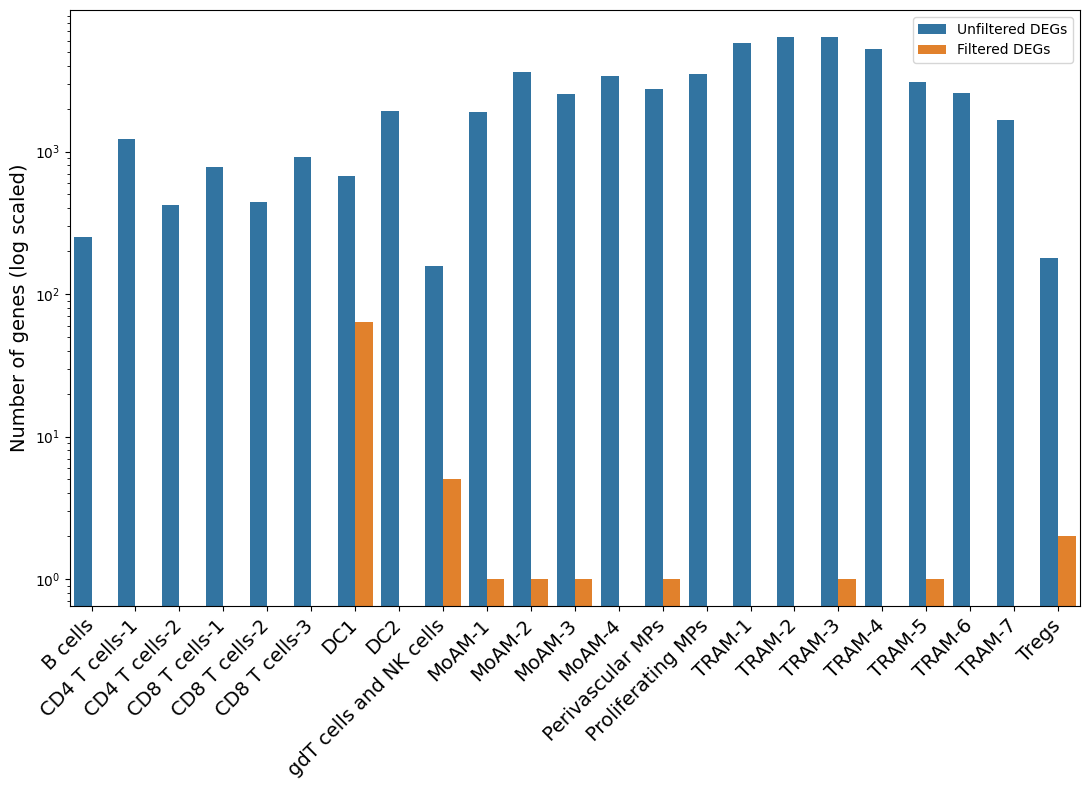

In [21]:
ax = sns.barplot(data=df, hue="variable", y="value", x="name", hue_order=["n_degs_unf", "n_degs"])
ax.figure.set_size_inches((11, 8))
ax.set_xticklabels(
    df.name[df.variable == "n_degs"], 
    rotation=45, 
    ha="right",
    fontsize=14
)
ax.set_ylabel("Number of genes (log scaled)", fontsize=14)
ax.set_xlabel("")
ax.legend_.get_texts()[0].set_text("Unfiltered DEGs")
ax.legend_.get_texts()[1].set_text("Filtered DEGs")
ax.legend_.set_title("")
plt.yscale('log')
trans = transforms.Affine2D().translate(6, 0)
for t in ax.get_xticklabels():
    t.set_transform(t.get_transform() + trans)
ax.figure.tight_layout()
ax.figure.savefig(f"{OUT_DIR}/01number-of-degs.png", bbox_inches='tight')
ax.figure.savefig(f"{OUT_DIR}/01number-of-degs.pdf", bbox_inches='tight')

## Summary
In this notebook, we filtered DEGs and generated heatmaps and MA plots for each cell type based on these filtered DEGs. This notebook also provided a direct comparison between the number of filtered and unfiltered DEGs per cluster.